# This notebook is used to create dataset for classification.
`Only bbox were used and polylines were skipped`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Official Folder DigitalTwins/Data/Annotated/Image_annotation_8images_batch1.zip"

Archive:  /content/drive/MyDrive/Official Folder DigitalTwins/Data/Annotated/Image_annotation_8images_batch1.zip
   creating: Image_annotation_8images_batch1/
   creating: Image_annotation_8images_batch1/classes/
  inflating: Image_annotation_8images_batch1/classes/classes.json  
  inflating: Image_annotation_8images_batch1/2001_3.png___objects.json  
  inflating: Image_annotation_8images_batch1/1414.png___objects.json  
  inflating: Image_annotation_8images_batch1/1420.png___objects.json  
  inflating: Image_annotation_8images_batch1/2001_2.png___objects.json  
  inflating: Image_annotation_8images_batch1/2201_1.png___objects.json  
  inflating: Image_annotation_8images_batch1/2001_1.png___objects.json  
  inflating: Image_annotation_8images_batch1/1422.png___objects.json  
  inflating: Image_annotation_8images_batch1/1421.png___objects.json  


In [ ]:
!unzip -d imgs "/content/drive/MyDrive/Official Folder DigitalTwins/Data/Not-Annotated/PIDs-images_200dpi.zip" 

Archive:  /content/drive/MyDrive/Official Folder DigitalTwins/Data/Not-Annotated/PIDs-images_200dpi.zip
  inflating: imgs/1414.png           
  inflating: imgs/1420.png           
  inflating: imgs/1421.png           
  inflating: imgs/1422.png           
  inflating: imgs/2001_1.png         
  inflating: imgs/2001_2.png         
  inflating: imgs/2001_3.png         
  inflating: imgs/2101.png           
  inflating: imgs/2201_1.png         
  inflating: imgs/2201_2.png         


In [ ]:
import json
import pandas as pd
import cv2
import random
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from skimage import io, transform
from PIL import Image
import torchvision as vision
from torchvision import transforms, datasets

In [ ]:
with open("/content/Image_annotation_8images_batch1/1414.png___objects.json") as f:
    anno = json.load(f)

In [ ]:
pip install superannotate

In [ ]:
import superannotate as sa
sa.export_annotation("/content/Image_annotation_8images_batch1", "/content/new", "COCO", "PID", project_type='Vector', task='object_detection')

In [ ]:
with open("/content/new/PID.json") as f:
    pid = json.load(f)

In [ ]:
pid.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
len(pid['annotations'])

6225

In [ ]:
pp = pd.DataFrame(pid)

In [ ]:
anno.keys()

dict_keys(['metadata', 'comments', 'tags', 'instances'])

In [ ]:
# Creating DataFrame of Instances
# All data associated to give image is under Instance key.
df = pd.DataFrame(anno['instances'])

In [ ]:
df.className.unique()

array(['Instrument', 'tank_vessel', 'engine', 'valve', 'flange', 'plug',
       'flange_blind', 'Concentric', 'Actuator', 'connector',
       'line_break', 'flow_direction', 'piping_lines', 'other_lines',
       'Unidentified', 'Inside text', 'text'], dtype=object)

In [ ]:
# Here only taking bbox and removing polylines
ddf = df[df.type == 'bbox']

In [ ]:
# piping_lines and other_lines are removed as they were polylines
ddf.className.unique()

array(['Instrument', 'tank_vessel', 'engine', 'valve', 'flange', 'plug',
       'flange_blind', 'Concentric', 'Actuator', 'connector',
       'line_break', 'flow_direction', 'Unidentified', 'Inside text',
       'text'], dtype=object)

In [ ]:
# Just copied from above cell
class_name_list = ['Instrument', 'tank_vessel', 'engine', 'separator', 'valve',
       'flange', 'plug', 'flange_blind', 'Concentric', 'Actuator',
       'connector', 'line_break', 'flow_direction', 
        'Unidentified', 'Inside text', 'text']

In [ ]:
'''
  The code below is used to create class folders based on the above class name list.
'''

main_dir = "/content/drive/MyDrive/cropped_img/"
for dir in class_name_list:
  if not os.path.exists(main_dir):
    os.makedirs(main_dir)
  if not os.path.exists(main_dir+dir):
    os.makedirs(main_dir+dir)

In [ ]:
def create_dataset(img, img_name, df):
  """ Function to create_dataset
    Params:
        img: image (use cv2.imread(img_path))
        img_name: name of the image, used to create new name for cropped images 
        df: dataframe which contain all information (Created using annotation file)
  """
  
  # Main directory name 
  main_dir = "/content/drive/MyDrive/cropped_img"

  for i in range(0, len(df['points'])):
    if df.type[i] != "polyline": # Skipping the polylines
      try :
        new_image_path = main_dir + "/" +str(df['className'][i])+ "/" + str(df['className'][i]) + "_{}_{}.jpg".format(img_name, i+1)
        if not os.path.exists(new_image_path):
          bbox = df.points[i]
          x1, x2, y1, y2 = int(bbox['x1']), int(bbox['x2']), int(bbox['y1']), int(bbox['y2'])
          crop_img = img[y1:y2, x1:x2] 
          print(df['className'][i], "--> ", new_image_path, crop_img.shape)
          cv2.imwrite(new_image_path, crop_img)
      except:
        pass

In [ ]:
# Getting all image annotation file path 
annotation_dir = "/content/Image_annotation_8images_batch1/"
img_anno = [(annotation_dir+f) for f in listdir(annotation_dir) if isfile(join(annotation_dir, f))]

In [ ]:
# Path of the image dir
img_dir = "/content/imgs/"

# Looping over annotation file
for i in img_anno:
  with open(i) as f:
    anno = json.load(f)
  img_name =  anno['metadata']['name']
  #Reading image
  img = cv2.imread(img_dir + img_name)
  
  # Creating DataFrame of instances list
  df = pd.DataFrame(anno['instances'])

  create_dataset(img, img_name.split(".")[0], df)

In [ ]:
ig = cv2.imread("/content/drive/MyDrive/cropped_img/Actuator/Actuator_251.jpg")
ig.shape

(58, 59, 3)

# Simple Dataloader for Classification part (WIP)

In [ ]:
def prepare_dataset(dataset_path):
  """ Function to create train and validation loader.
    Params:
        dataset_path: path where all images are.
    
    returns: 
        train_loader: train loader with batch size of 64
        validation_loader: validation loader with batch size of 64
        
    Note: Split ratio and batch sizes are pre-defined you can change it in this function.
    """

  labels = os.listdir(dataset_path)

  # Here images are resized and converted to grayscale so that we have data consistency for other tasks
  dataset = ImageFolder(
      dataset_path,
      transforms.Compose([transforms.Resize((32,32)),
                         transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])
  )
  
  # Validation split 15%
  val_split = int(len(dataset)*0.15)
  train_split = len(dataset) - val_split

  train_dataset, val_dataset = random_split(dataset, [train_split, val_split])

  # to make sure the split is right.
  assert (len(train_dataset)+len(val_dataset)) == len(dataset)

  train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(val_dataset, 128) 

  return (train_loader, validation_loader)

In [ ]:
dataset_dir = "/content/drive/MyDrive/cropped_img"
train_loader, validation_loader = prepare_dataset(dataset_dir)

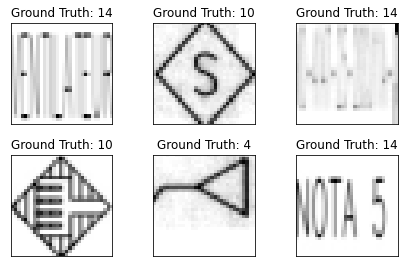

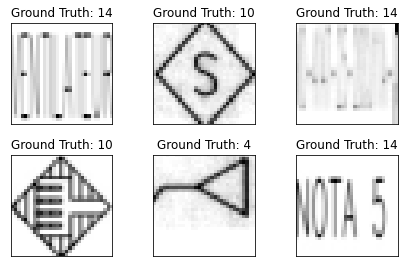

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig